<a href="https://colab.research.google.com/github/Aryan-Shrivastva/Image-Identification/blob/main/Image_Identification_through_ViT_model_using_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Importing libraries


In [ ]:
import torch
import torch.nn as nn #nn is a submodule inside torch that contains lots of layers & loss function
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm
import numpy as np
import random
import matplotlib.pyplot as plt

In [ ]:
torch.__version__

'2.6.0+cu124'

In [ ]:
torchvision.__version__

'0.21.0+cu124'

In [ ]:
## 2. Setup Device-Agnostic code

# 2. Setup Device-Agnostic code

In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
torch.cuda.is_available()


False

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [ ]:
print(f"Using Device: {device}")

Using Device: cpu


# 3. Set the Seed

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
random.seed(42)

# 4. Setting the Hyperparameters

In [ ]:
BATCH_SIZE = 128
EPOCHS = 10
LEARNING_RATE = 3e-4
PATCH_SIZE = 4
NUM_CLASSES = 10
IMAGE_SIZE = 32
CHANNELS = 3
EMBED_DIM = 256
NUM_HEADS = 8
DEPTH = 6
MLP_DIM = 512
DROP_RATE = 0.1

# 5. Define Image Transformations

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
    #Helps the model to converge faster
    #Helps to make the numerical computations stable
])

# transform_train = transforms.Compose([
#     transforms.RandomCrop(32, padding=4),
#     transforms.RandomHorizontalFlip(),
#     transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
# ]) Try these commented as it will habve change in train and test accuracy and loss

# 6. Getting a dataset


In [ ]:
train_dataset = datasets.CIFAR10(root="data",
                                 train=True,
                                 download=True,
                                 transform=transform)

In [ ]:
test_dataset = datasets.CIFAR10(root="data",
                                train = False,
                                download = True,
                                transform = transform)

In [ ]:
train_dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )

In [ ]:
test_dataset

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )

In [ ]:
len(train_dataset)

50000

In [ ]:
len(test_dataset)

10000

# 7. Converting our datasets into dataloaders

Right now, our data is in the form of PyTorch dataset

DataLoader turns our data into batches or mini-batches

Why would we do this?

1. It is more computationally efficient, as in, your computing hardware may not be able to look (store in memory) at 50000 images in one hit. So we break it into 128 images at a time. (batch size of 128).

2. It gives our neural network more chances to update its gradients per epoch

In [ ]:
BATCH_SIZE

128

In [ ]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False)

In [ ]:
# Lets check out what we've created
print(f"DataLoader: {train_loader, test_loader}")
print(f"Length of Train Loader: {len(train_loader)} batches of {BATCH_SIZE}...")
print(f"Length of Test Loader: {len(test_loader)} batches of {BATCH_SIZE}...")

DataLoader: (<torch.utils.data.dataloader.DataLoader object at 0x781e0cde2510>, <torch.utils.data.dataloader.DataLoader object at 0x781e0cf4c750>)
Length of Train Loader: 391 batches of 128...
Length of Test Loader: 79 batches of 128...


In [ ]:
128*391

50048

In [ ]:
50000/128

390.625

# Building Vision Transformer from Scrach


In [ ]:
PATCH_SIZE

4

In [ ]:
class PatchEmbedding(nn.Module):
    def __init__(self,
               img_size,
               patch_size,
               in_channels,
               embed_dim):
        super().__init__()
        self.patch_size = patch_size
        self.proj = nn.Conv2d(in_channels=in_channels,
                                    out_channels=embed_dim,
                                    kernel_size=patch_size,
                                    stride=patch_size)
        num_patches = (img_size // patch_size) ** 2
        self.cls_token = nn.Parameter(torch.randn(1,1, embed_dim))
        self.pos_embed = nn.Parameter(torch.randn(1, 1 + num_patches, embed_dim))

    def forward(self, x: torch.Tensor):
        B = x.size(0)
        x = self.proj(x) #(B, E, H/P, W/P)
        x = x.flatten(2).transpose(1,2) #(B,N,E)
        cls_token = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_token, x), dim=1)
        x = x+ self.pos_embed
        return x

In [ ]:
F

<module 'torch.nn.functional' from '/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py'>

In [ ]:
#Multi Layer Perceptron class
class MLP(nn.Module):
    def __init__(self,
               in_features,
               hidden_features,
               drop_rate):
        super().__init__()
        self.fc1 = nn.Linear(in_features=in_features,
                             out_features=hidden_features)
        self.fc2 = nn.Linear(in_features=hidden_features,
                             out_features=in_features)
        self.dropout = nn.Dropout(p=drop_rate)

    def forward(self, x):
        x = self.dropout(F.gelu(self.fc1(x)))
        x = self.dropout(self.fc2(x))
        return x

In [ ]:
class TransformerEncoderLayer(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_dim, drop_rate):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=drop_rate, batch_first = True)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = MLP(embed_dim, mlp_dim, drop_rate)
    def forward(self, x):
        x = x + self.attn(self.norm1(x), self.norm1(x), self.norm1(x))[0]
        x = x + self.mlp(self.norm2(x))
        return x

In [ ]:
class VisionTransformer(nn.Module):
    def __init__(self, img_size, patch_size, in_channels, num_classes, embed_dim, depth, num_heads, mlp_dim, drop_rate):
        super().__init__()
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        self.encoder = nn.Sequential(*
         [TransformerEncoderLayer(embed_dim, num_heads, mlp_dim, drop_rate)
         for _ in range(depth)
         ])
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)
    def forward(self, x):
        x = self.patch_embed(x)
        x = self.encoder(x)
        x = self.norm(x)
        cls_token = x[:, 0]
        return self.head(cls_token)

In [ ]:
device

'cpu'

In [ ]:
# Instantiate model
model = VisionTransformer(
    IMAGE_SIZE, PATCH_SIZE, CHANNELS, NUM_CLASSES, EMBED_DIM,
    DEPTH, NUM_HEADS, MLP_DIM, DROP_RATE
).to(device)

In [ ]:
model

VisionTransformer(
  (patch_embed): PatchEmbedding(
    (proj): Conv2d(3, 256, kernel_size=(4, 4), stride=(4, 4))
  )
  (encoder): Sequential(
    (0): TransformerEncoderLayer(
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP(
        (fc1): Linear(in_features=256, out_features=512, bias=True)
        (fc2): Linear(in_features=512, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (1): TransformerEncoderLayer(
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP

# Defining a Loss Function and an optimizer

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters(),
                             lr = LEARNING_RATE)

In [ ]:
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0003
    maximize: False
    weight_decay: 0
)

# Defining a Training Loop Function

In [ ]:
device

'cpu'

In [ ]:
def train(model, loader, optimizer, criterion):
    #set the mode of the model into training
    model.train()

    total_loss, correct = 0, 0

    for x, y in loader:
        #Moving (Sending) our data into the target device
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        #1. Forward pass(model output raw logits)
        out = model(x)
        #.2 Calculate loss(per batch)
        loss = criterion(out, y)
        #.3 Perform backpropagation
        loss.backward()
        #.4 Perform Gradient Descent
        optimizer.step()

        total_loss += loss.item() * x.size(0)
        correct += (out.argmax(1) == y).sum().item()
    # We have to scale the loss (Normalization step to make the loss general across all batches)
    return total_loss / len(loader.dataset), correct / len(loader.dataset)

In [ ]:
def ecaluate(model, loader):
    model.eval() # Set the mode of the model into evaluation
    correct = 0
    with torch.inference_mode():
        for x,y in loader:
            x,y = x.to(device), y.to(device)
            out = model(x)
            correct +=(out.argmax(dim=1) == y).sum().item()
    return correct / len(loader.dataset)

In [ ]:
from tqdm.auto import tqdm

In [ ]:
## Training
train_accuracies, test_accuracies = [], []

for epoch in tqdm(range(EPOCHS)):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    test_acc = ecaluate(model, test_loader)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    print(f"Epoch: {epoch+1}/{EPOCHS}, Train loss: {train_loss:.4f}, Train acc: {train_acc:.4f}%, Test acc: {test_acc:.4f}")


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1/10, Train loss: 1.7305, Train acc: 0.3740%, Test acc: 0.4380
Epoch: 2/10, Train loss: 1.3886, Train acc: 0.5031%, Test acc: 0.5272
Epoch: 3/10, Train loss: 1.2376, Train acc: 0.5579%, Test acc: 0.5657
Epoch: 4/10, Train loss: 1.1290, Train acc: 0.5958%, Test acc: 0.5743
Epoch: 5/10, Train loss: 1.0412, Train acc: 0.6285%, Test acc: 0.6086
Epoch: 6/10, Train loss: 0.9703, Train acc: 0.6536%, Test acc: 0.6129
Epoch: 7/10, Train loss: 0.8912, Train acc: 0.6826%, Test acc: 0.6166
Epoch: 8/10, Train loss: 0.8220, Train acc: 0.7056%, Test acc: 0.6211
Epoch: 9/10, Train loss: 0.7534, Train acc: 0.7312%, Test acc: 0.6268
Epoch: 10/10, Train loss: 0.6785, Train acc: 0.7577%, Test acc: 0.6370


In [ ]:
train_accuracies

[0.37404,
 0.5031,
 0.55788,
 0.59576,
 0.62846,
 0.65358,
 0.68256,
 0.70562,
 0.73116,
 0.75766]

In [ ]:
test_accuracies

[0.438, 0.5272, 0.5657, 0.5743, 0.6086, 0.6129, 0.6166, 0.6211, 0.6268, 0.637]

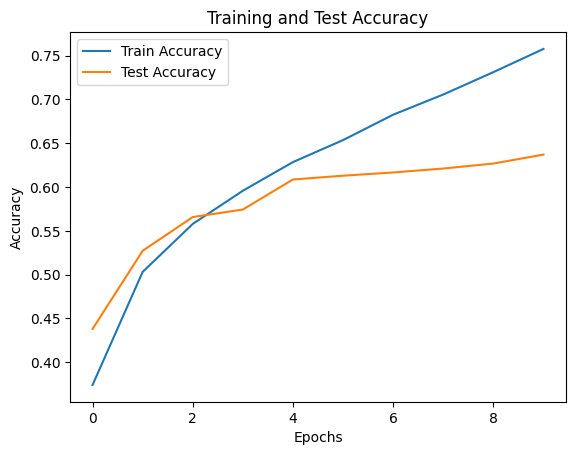

In [ ]:
#Plot accuracy
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(test_accuracies, label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training and Test Accuracy")
plt.show()

In [ ]:
import random

In [ ]:
len(test_dataset)

10000

In [ ]:
test_dataset[0][0].shape # 3 channels, 32 height, 32 width

torch.Size([3, 32, 32])

In [ ]:
test_dataset[0][0].unsqueeze(dim=0).shape

torch.Size([1, 3, 32, 32])

In [ ]:
def predict_and_plot_grid(model,
                          datasets,
                          classes,
                          grid_size=4):
    model.eval()
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(10,10))
    for i in range(grid_size):
        for j in range(grid_size):
            idx = random.randint(0, len(datasets)-1)
            img, true_label = datasets[idx]
            input_tensor = img.unsqueeze(dim=0).to(device)
            with torch.inference_mode():
                output = model(input_tensor)
                _, predicted = torch.max(output.data, 1)

            # Check if axes is a 1D array or 2D array
            if grid_size == 1:
                ax = axes
            elif grid_size > 1:
                ax = axes[i, j]
            else:
                 ax = axes[0]

            img = img / 2 + 0.5 # unnormalixe our images to be able to plot them with matplotlib
            npimg = img.cpu().numpy()
            ax.imshow(np.transpose(npimg, (1,2,0)))
            truth = classes[true_label] == classes[predicted.item()]
            if truth:
                color = "g"
            else:
                color = "r" # Changed 'c' to 'color' for consistency and correctness

            ax.set_title(f"Truth: {classes[true_label]}\nPredicted: {classes[predicted.item()]}", fontsize = 10, color=color) # Corrected newline character and dot
            ax.axis("off")
    plt.tight_layout()
    plt.show()

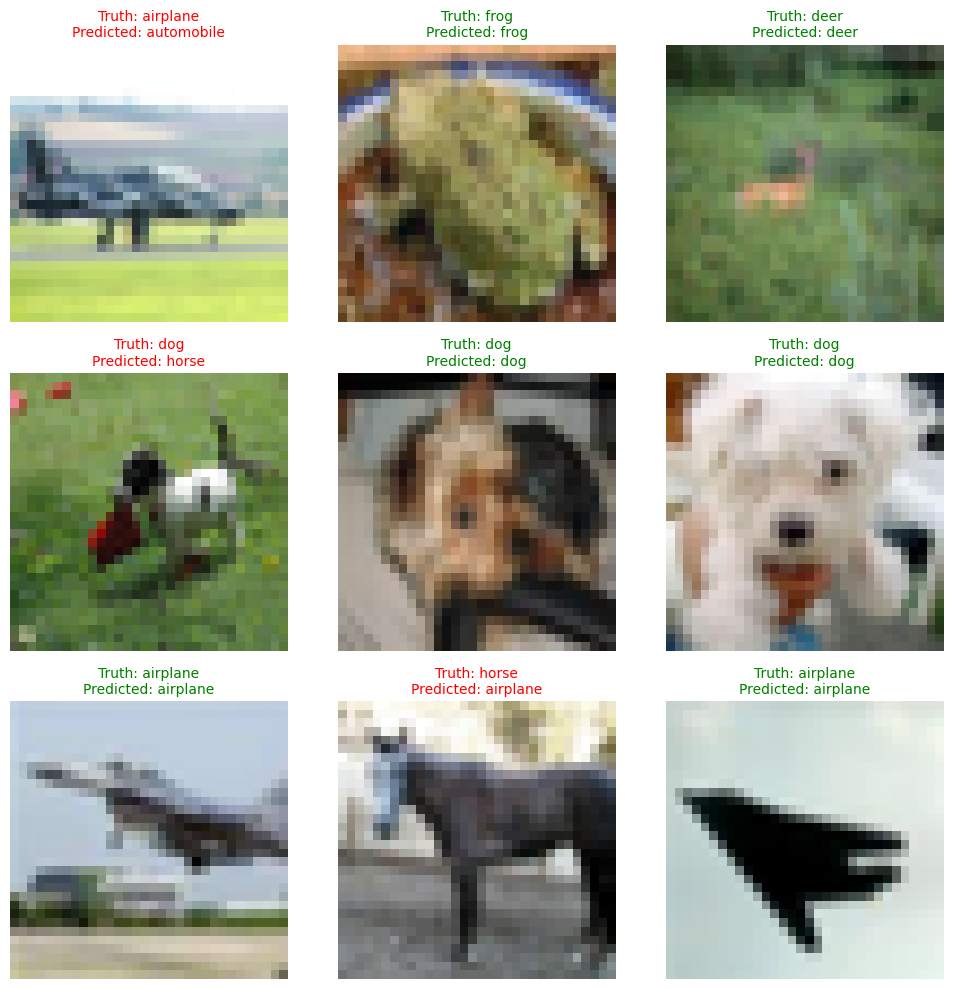

In [ ]:
predict_and_plot_grid(model, test_dataset, classes=train_dataset.classes, grid_size=3)